In [ ]:
# fix for windows memory leak with MKL
import os
import platform

if platform.system() == "Windows":
    os.environ["OMP_NUM_THREADS"] = "2"

# import libraries
import time
import random
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # this is used for the plot of the graph
from scipy.stats import mode
from scipy.stats import zscore
from scipy.stats import median_abs_deviation
import joblib
# Sklearn classes
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    KFold,
)
from sklearn import metrics
from sklearn.metrics import confusion_matrix, silhouette_score, make_scorer, recall_score, f1_score
import sklearn.metrics.cluster as smc
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    MinMaxScaler,
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import tree
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_blobs
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from helper import (
    draw_confusion_matrix,
    heatmap,
    make_meshgrid,
    plot_contours,
    draw_contour,
)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Sets random seed for reproducibility
SEED = 42
random.seed(SEED)

In [23]:
# Load Data
data = pd.read_csv("Data_Raw.csv", header=1)
sites = data['site']
niki = pd.read_csv("Data_Niki.csv")
niki = niki.drop(index=[0,1])
niki['Engineer classification.1'] = (niki['Engineer classification.1'] == 'Release').astype(int)
y = niki['Engineer classification.1']

# Dropping Unnecessary Rows and Columns
filtered_ordered_columns = [col for col in niki['Parameter name'] if col in data.columns]
data = data[filtered_ordered_columns]
data = pd.concat([sites, data], axis=1)
data = data.apply(pd.to_numeric, errors='coerce') 

# Obtaining Median and Std for Each Site and Each Parameter
med = data.groupby('site').median()
std = data.groupby('site').std()

# med = med.fillna(0)
# std = std.fillna(0)

med = med.T.copy()
std = std.T.copy()

C:\Users\nxg15046\AppData\Local\Temp\1\ipykernel_23056\3059869606.py:4: DtypeWarning: Columns (1,2,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255

In [24]:
# Standardizing by Row
z_med = med.apply(zscore, axis=1, nan_policy='omit')
z_med = pd.DataFrame(z_med.tolist(), index=med.index, columns=med.columns)
z_std = std.apply(zscore, axis=1, nan_policy='omit')
z_std = pd.DataFrame(z_std.tolist(), index=std.index, columns=std.columns)

In [25]:
# Range (need to remove lower and upper limit)
z_med_min = z_med.min(axis=1)
z_std_min = z_std.min(axis=1)
z_med_max = z_med.max(axis=1)
z_std_max = z_std.max(axis=1)
z_med_range = z_med_max - z_med_min
z_std_range = z_std_max - z_std_min

## Inter-Quartile Range
Q1_med = z_med.quantile(0.25, axis=1)
Q3_med = z_med.quantile(0.75, axis=1)
z_med_iqr = Q3_med - Q1_med
Q1_std = z_std.quantile(0.25, axis=1)
Q3_std = z_med.quantile(0.75, axis=1)
z_std_iqr = Q3_std - Q1_std

## Median Absolute Deviation
z_med_mad = z_med.apply(median_abs_deviation, axis=1)
z_std_mad = z_std.apply(median_abs_deviation, axis=1)

## Skewness
med_skewness = med.skew(axis=1)
std_skewness = std.skew(axis=1)

## Kurtosis (Propensity for Outliers)
med_kurtosis = med.kurt(axis=1)
std_kurtosis = std.kurt(axis=1)

In [26]:
# Concatenating All Features
y.index = z_med.index
x = pd.concat([z_med_range, z_std_range, z_med_iqr, z_std_iqr, z_med_mad, z_std_mad, med_skewness, std_skewness, med_kurtosis, std_kurtosis, y], axis=1)

# Assigning New Column Names to Bypass Column Name Repeating Issue
num_columns = x.shape[1]
x.columns = x.columns.astype(str)
new_columns = ["z_med_range", "z_std_range", "z_med_iqr", "z_std_iqr", "z_med_mad", "z_std_mad", "med_skewness", "std_skewness", "med_kurtosis", "std_kurtosis", "y"]
x.columns = new_columns

corr_matrix = x.corr(numeric_only=True)
print(corr_matrix["y"].sort_values(ascending=False))
x = x.drop('y', axis=1)

y               1.000000
z_med_mad       0.651143
z_med_iqr       0.560460
med_skewness    0.424884
z_std_iqr       0.396754
z_std_mad       0.229869
std_kurtosis   -0.081305
std_skewness   -0.150456
z_std_range    -0.165742
z_med_range    -0.689467
med_kurtosis   -0.743451
Name: y, dtype: float64


In [27]:
# Train Test Split
train_raw, test_raw, target, target_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=0)

# Applying Pipeline to Train and Test Data
categorical_features = x.select_dtypes(exclude=["number"]).columns.tolist()
numerical_features = x.select_dtypes(include=["number"]).columns.tolist()
num_pipeline = Pipeline([("normalizer", StandardScaler())])
full_pipeline = ColumnTransformer([("num", num_pipeline, numerical_features), ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features)])

train = full_pipeline.fit_transform(train_raw)
test = full_pipeline.transform(test_raw)

joblib.dump(full_pipeline, 'pipeline_noimpute.pkl')

['pipeline_noimpute.pkl']

In [38]:
# Decision Tree Classifier

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

f1_scorer = make_scorer(recall_score, pos_label=0)
clf_parameters = [{"max_depth": [2,4,8,16,32,64], "min_samples_split": [2,4,8,16], "criterion": ['gini', 'entropy']}]
clf = DecisionTreeClassifier(class_weight='balanced', random_state=42)
grid = GridSearchCV(clf, clf_parameters, cv = kf, scoring=f1_scorer)
grid.fit(train,target)
clf_res = pd.DataFrame(grid.cv_results_)
clf_predicted = grid.predict(test)
best_params_dt = grid.best_params_
relevant_columns = ['rank_test_score', 'mean_test_score', 'std_test_score']
top_3_models = clf_res[relevant_columns].sort_values(by='rank_test_score').head(3)
print(top_3_models)

    rank_test_score  mean_test_score  std_test_score
15                1         0.898246         0.02163
11                1         0.898246         0.02163
23                1         0.898246         0.02163


In [39]:
# XGBoost

xgb_params = {
    "n_estimators": [100, 200],
    "max_depth": [4, 6, 10],
    "learning_rate": [0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "scale_pos_weight": [5, 6],
    "gamma": [0, 1, 5]
}

xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_grid = GridSearchCV(xgb, xgb_params, cv=kf, scoring=f1_scorer, n_jobs=-1, verbose=1)
xgb_grid.fit(train, target)
xgb_res = pd.DataFrame(xgb_grid.cv_results_)
best_params_xgb = xgb_grid.best_params_
relevant_columns = ['rank_test_score', 'mean_test_score', 'std_test_score']

top_3_xgb = xgb_res[relevant_columns].sort_values(by='rank_test_score').head(3)
print("\nTop 3 XGBoost Models:")
print(top_3_xgb)

Fitting 3 folds for each of 144 candidates, totalling 432 fits

Top 3 XGBoost Models:
    rank_test_score  mean_test_score  std_test_score
12                1         0.831579        0.030989
6                 2         0.828070        0.030184
5                 2         0.828070        0.035783


In [40]:
# LightGBM

lgbm_params = {
    "n_estimators": [300],
    "max_depth": [-1,],
    "learning_rate": [0.05, 0.1],
    "num_leaves": [31, 50, 100],
    "min_child_samples": [10, 20, 30],
    "colsample_bytree": [0.8, 1.0],
    "scale_pos_weight": [5, 6],
}

lgbm = LGBMClassifier(random_state=42)
lgbm_grid = GridSearchCV(lgbm, lgbm_params, cv=kf, scoring=f1_scorer, n_jobs=-1, verbose=1)
lgbm_grid.fit(train, target)
lgbm_res = pd.DataFrame(lgbm_grid.cv_results_)
best_params_lgbm = lgbm_grid.best_params_
relevant_columns = ['rank_test_score', 'mean_test_score', 'std_test_score']

top_3_lgbm = lgbm_res[relevant_columns].sort_values(by='rank_test_score').head(3)
print("\nTop 3 LightGBM Models:")
print(top_3_lgbm)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[LightGBM] [Info] Number of positive: 1584, number of negative: 285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2038
[LightGBM] [Info] Number of data points in the train set: 1869, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.847512 -> initscore=1.715219
[LightGBM] [Info] Start training from score 1.715219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [41]:
# Random Forest

rf_params = {
    "n_estimators": [200, 300],
    "max_depth": [None, 16, 32],
    "min_samples_split": [2, 4, 8],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ['sqrt', 'log2'],
    "criterion": ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_grid = GridSearchCV(rf, rf_params, cv=kf, scoring=f1_scorer, n_jobs=-1, verbose=1)
rf_grid.fit(train, target)
rf_res = pd.DataFrame(rf_grid.cv_results_)
best_params_rf = rf_grid.best_params_
relevant_columns = ['rank_test_score', 'mean_test_score', 'std_test_score']

top_3_rf = rf_res[relevant_columns].sort_values(by='rank_test_score').head(3)
print("\nTop 3 Random Forest Models:")
print(top_3_rf)
print("\nBest Random Forest Parameters:", rf_grid.best_params_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits



Top 3 Random Forest Models:
    rank_test_score  mean_test_score  std_test_score
11                1         0.877193        0.009924
29                1         0.877193        0.009924
47                1         0.877193        0.009924

Best Random Forest Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 300}


Fit Time:    0.018259 seconds
Prediction Time: 0.001273 seconds
Test Accuracy: 0.960100
Precision:   0.868852
Recall:      0.868852
F1 Score:    0.868852


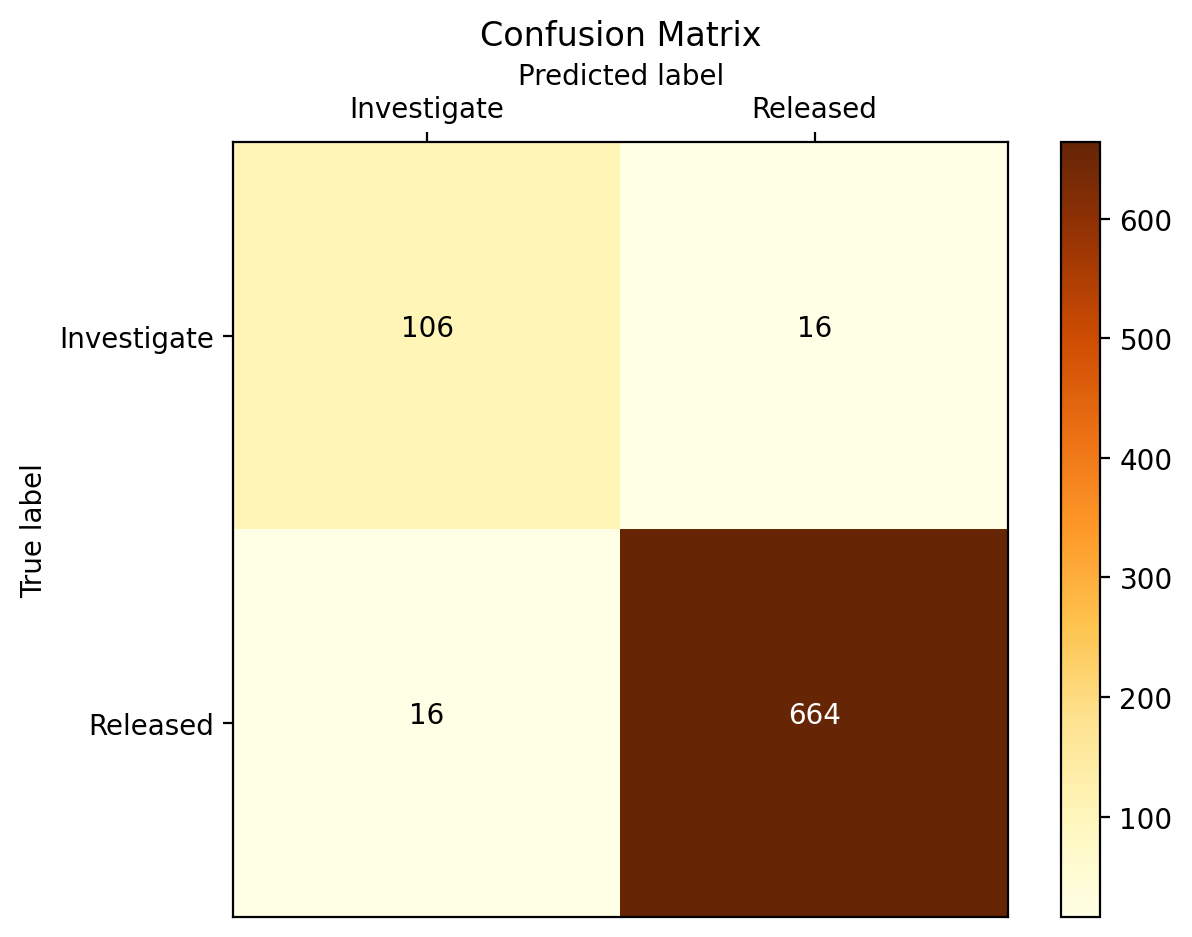

In [42]:
# Best Decision Tree

# Measure fit time
start_fit = time.time()
dt = DecisionTreeClassifier(**best_params_dt, random_state=42)
dt.fit(train, target)
joblib.dump(dt, 'dt_raw_noimpute.pkl')
end_fit = time.time()
fit_time = end_fit - start_fit

# Measure prediction time
start_pred = time.time()
predicted = dt.predict(test)
dt_results = predicted
end_pred = time.time()
pred_time = end_pred - start_pred

# Metrics
accuracy = metrics.accuracy_score(target_test, predicted)
precision = precision_score(target_test, predicted, pos_label=0)
recall = recall_score(target_test, predicted, pos_label=0)
f1 = f1_score(target_test, predicted, pos_label=0)

# Print Results
print("%-12s %f seconds" % ('Fit Time:', fit_time))
print("%-12s %f seconds" % ('Prediction Time:', pred_time))
print("%-12s %f" % ('Test Accuracy:', accuracy))
print("%-12s %f" % ('Precision:', precision))
print("%-12s %f" % ('Recall:', recall))
print("%-12s %f" % ('F1 Score:', f1))

dt_metrics = ['Decision Tree', accuracy, precision, recall, f1, fit_time, pred_time]
draw_confusion_matrix(target_test, predicted, ['Investigate', 'Released'])

Fit Time:    0.407341 seconds
Prediction Time: 0.009254 seconds
Test Accuracy: 0.977556
Precision:   0.919355
Recall:      0.934426
F1 Score:    0.926829


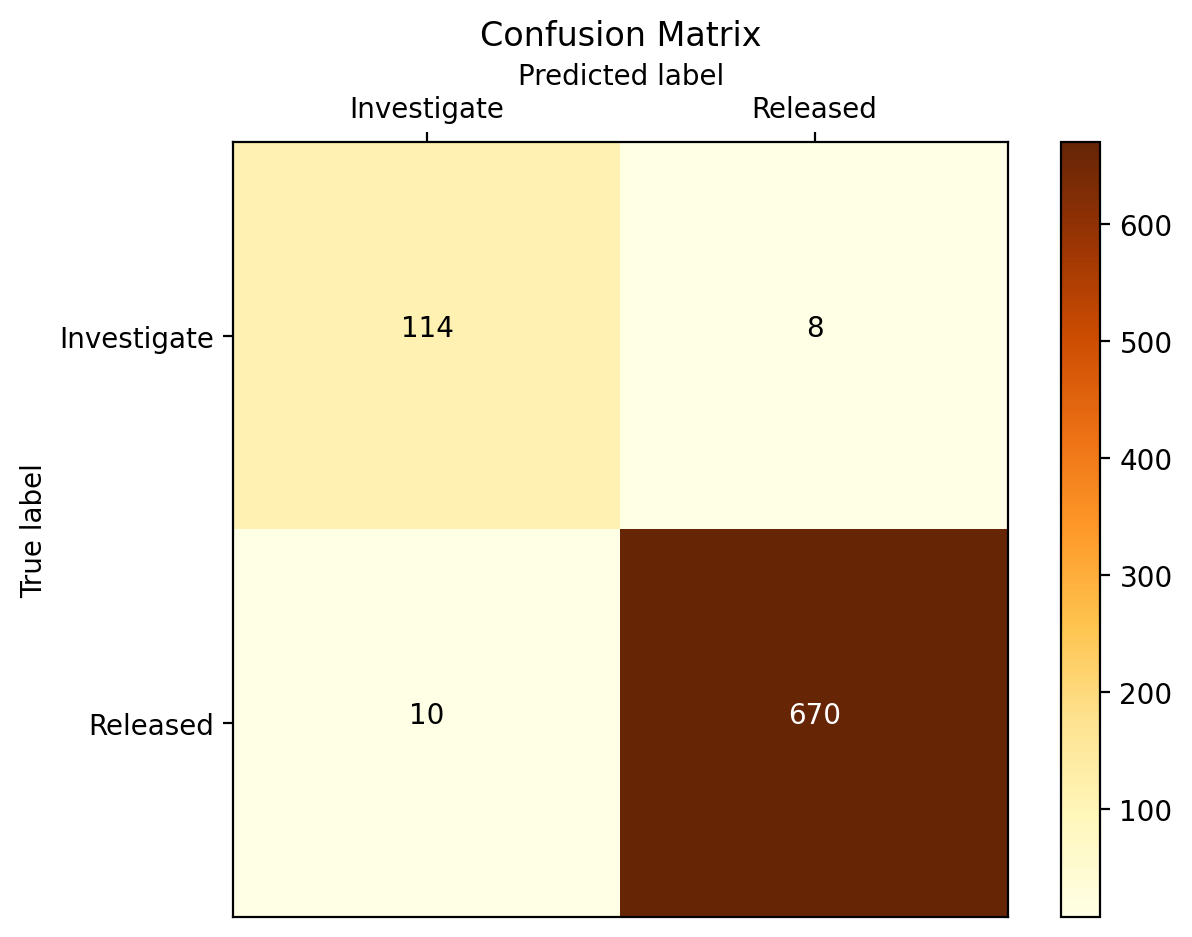

In [43]:
# Best XGBoost

# Measure fit time
start_fit = time.time()
xgb = XGBClassifier(**best_params_xgb, random_state=42)
xgb.fit(train, target)
end_fit = time.time()
fit_time = end_fit - start_fit

# Measure prediction time
start_pred = time.time()
predicted = xgb.predict(test)
xgb_results = predicted
end_pred = time.time()
pred_time = end_pred - start_pred

# Metrics
accuracy = metrics.accuracy_score(target_test, predicted)
precision = precision_score(target_test, predicted, pos_label=0)
recall = recall_score(target_test, predicted, pos_label=0)
f1 = f1_score(target_test, predicted, pos_label=0)

# Print Results
print("%-12s %f seconds" % ('Fit Time:', fit_time))
print("%-12s %f seconds" % ('Prediction Time:', pred_time))
print("%-12s %f" % ('Test Accuracy:', accuracy))
print("%-12s %f" % ('Precision:', precision))
print("%-12s %f" % ('Recall:', recall))
print("%-12s %f" % ('F1 Score:', f1))

xgb_metrics = ['XGBoost', accuracy, precision, recall, f1, fit_time, pred_time]
draw_confusion_matrix(target_test, predicted, ['Investigate', 'Released'])

[LightGBM] [Info] Number of positive: 1584, number of negative: 285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2038
[LightGBM] [Info] Number of data points in the train set: 1869, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.847512 -> initscore=1.715219
[LightGBM] [Info] Start training from score 1.715219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

c:\Users\nxg15046\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fit Time:    0.620321 seconds
Prediction Time: 0.022230 seconds
Test Accuracy: 0.973815
Precision:   0.904000
Recall:      0.926230
F1 Score:    0.914980


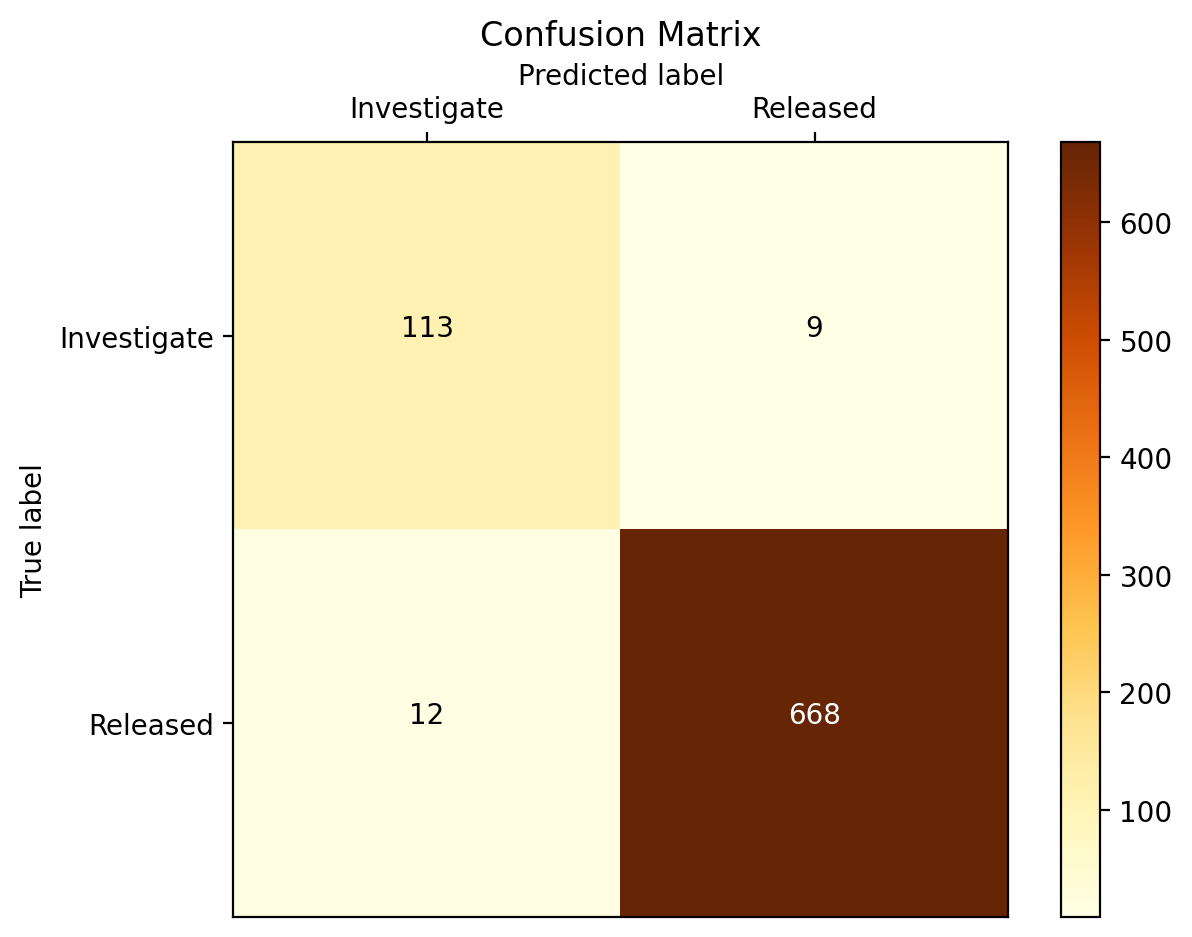

Best LightGBM Parameters:
colsample_bytree: 0.8
learning_rate: 0.1
max_depth: -1
min_child_samples: 30
n_estimators: 300
num_leaves: 50
scale_pos_weight: 5


In [44]:
# Best LightGBM

# Measure fit time
start_fit = time.time()
lgbm = LGBMClassifier(**best_params_lgbm, random_state=42)
lgbm.fit(train, target)
joblib.dump(lgbm, 'lgbm_raw_noimpute.pkl')
end_fit = time.time()
fit_time = end_fit - start_fit

# Measure prediction time
start_pred = time.time()
predicted = lgbm.predict(test)
lgbm_results = predicted
end_pred = time.time()
pred_time = end_pred - start_pred

# Metrics
accuracy = metrics.accuracy_score(target_test, predicted)
precision = precision_score(target_test, predicted, pos_label=0)
recall = recall_score(target_test, predicted, pos_label=0)
f1 = f1_score(target_test, predicted, pos_label=0)

# Print Results
print("%-12s %f seconds" % ('Fit Time:', fit_time))
print("%-12s %f seconds" % ('Prediction Time:', pred_time))
print("%-12s %f" % ('Test Accuracy:', accuracy))
print("%-12s %f" % ('Precision:', precision))
print("%-12s %f" % ('Recall:', recall))
print("%-12s %f" % ('F1 Score:', f1))

lgbm_metrics = ['LightGBM', accuracy, precision, recall, f1, fit_time, pred_time]
draw_confusion_matrix(target_test, predicted, ['Investigate', 'Released'])

# Print Best Parameters
print("Best LightGBM Parameters:")
for param, value in best_params_lgbm.items():
    print(f"{param}: {value}")


Fit Time:    1.159953 seconds
Prediction Time: 0.032587 seconds
Test Accuracy: 0.965087
Precision:   0.898305
Recall:      0.868852
F1 Score:    0.883333


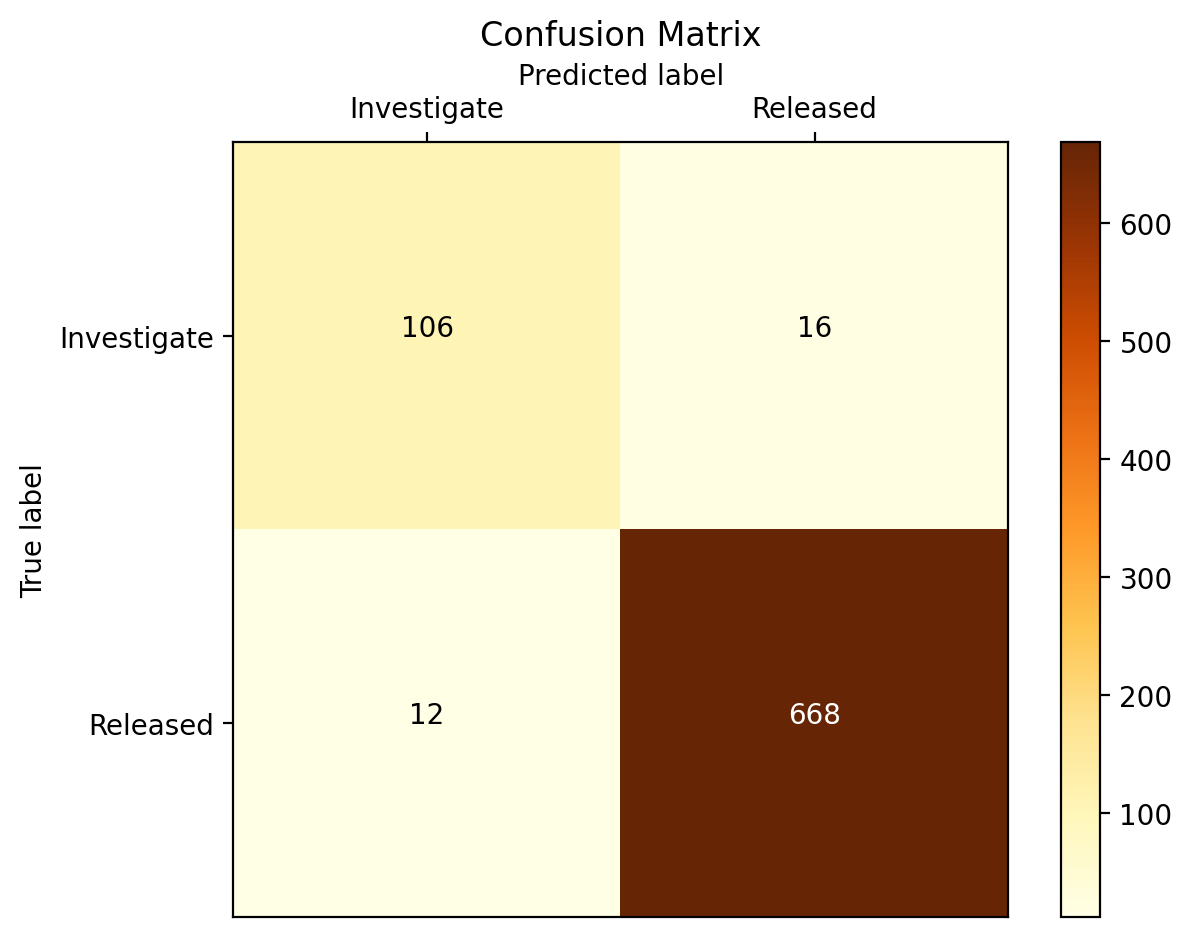

In [45]:
# Best Random Forest

# Measure fit time
start_fit = time.time()
rf = RandomForestClassifier(**best_params_rf, random_state=42)
rf.fit(train, target)
end_fit = time.time()
fit_time = end_fit - start_fit

# Measure prediction time
start_pred = time.time()
predicted = rf.predict(test)
rf_results = predicted
end_pred = time.time()
pred_time = end_pred - start_pred

# Metrics
accuracy = metrics.accuracy_score(target_test, predicted)
precision = precision_score(target_test, predicted, pos_label=0)
recall = recall_score(target_test, predicted, pos_label=0)
f1 = f1_score(target_test, predicted, pos_label=0)

# Print Results
print("%-12s %f seconds" % ('Fit Time:', fit_time))
print("%-12s %f seconds" % ('Prediction Time:', pred_time))
print("%-12s %f" % ('Test Accuracy:', accuracy))
print("%-12s %f" % ('Precision:', precision))
print("%-12s %f" % ('Recall:', recall))
print("%-12s %f" % ('F1 Score:', f1))

rf_metrics = ['Random Forest', accuracy, precision, recall, f1, fit_time, pred_time]
draw_confusion_matrix(target_test, predicted, ['Investigate', 'Released'])

In [46]:
# Summary Table of All Metrics

all_metrics = [dt_metrics, rf_metrics, xgb_metrics, lgbm_metrics]

# Create a DataFrame
metrics_df = pd.DataFrame(all_metrics, columns=[
    'Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Fit Time (s)', 'Prediction Time (s)'
])

# Print the table
metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
print(metrics_df.to_string(index=False))


        Model  Accuracy  Precision   Recall  F1 Score  Fit Time (s)  Prediction Time (s)
      XGBoost  0.977556   0.919355 0.934426  0.926829      0.407341             0.009254
     LightGBM  0.973815   0.904000 0.926230  0.914980      0.620321             0.022230
Random Forest  0.965087   0.898305 0.868852  0.883333      1.159953             0.032587
Decision Tree  0.960100   0.868852 0.868852  0.868852      0.018259             0.001273
